# Kaggle 预测房价

In [1]:
import hashlib      # 用于生成文件的哈希值（如md5，用于文件校验）
import os           # 操作系统相关操作，例如文件路径、文件遍历等
import tarfile      # 处理 .tar, .tar.gz, .tgz 等压缩文件（打包与解包）
import zipfile      # 处理 .zip 文件的压缩与解压
import requests     # 用于发送http请求，常用于下载文件

In [2]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')):
    # 确保传入的 name 必须在 DATA_HUB 字典中，否则抛出异常并提示用户
    # 逗号后面是断言不满足时的错误提示信息
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        # 如果文件的SHA-1哈希值与期望值一致，说明文件已正确下载且未被篡改
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f"正在从{url}下载{fname}...")
    r= requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    
    if ext == 'zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz', '.xxx'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False #'直接报错'
    fp.extractall(base_dir)
    # 如果指定了folder参数，则返回 base_dir 和 folder 拼接成的路径；
    # 否则，返回解压后的文件夹路径（去掉后缀的路径）。
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    for name in DATA_HUB:
        download(name)

In [5]:
import pandas as pd
import numpy as np
import torch
from d2l import torch as d2l
from torch import nn

In [6]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [8]:
print(train_data.shape)
print(test_data.shape)

print(train_data.__class__)

(1460, 81)
(1459, 80)
<class 'pandas.core.frame.DataFrame'>


In [9]:
print(train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [10]:
# pd.concat用于将多个DataFrame按指定轴拼接在一起。
# 这里将训练集除了第1列（ID）和最后1列（标签）以外的所有特征，与测试集除了第1列外的所有特征在“行”方向（默认axis=0）拼接，得到全部特征数据。
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [11]:
print(all_features.shape)

(2919, 79)


In [12]:
# 选取所有数值类型（即非object类型：比如int、float等）的特征列名
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
numeric_features.shape,numeric_features.__class__
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [13]:
# 标准化数值特征：减去均值，除以标准差
# apply() 会对每一列（数值特征）应用 lambda 函数
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# 标准化后，所有数值特征的均值变为0，标准差变为1
# 将缺失值（NaN）填充为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [14]:
# pd.get_dummies() 将类别特征（object类型）转换为独热编码（one-hot encoding）
# dummy_na=True 表示为缺失值（NaN）也创建一个独热列
# 例如：特征"MSZoning"有["RL", "RM", NaN]，会转换为3列：MSZoning_RL, MSZoning_RM, MSZoning_nan
all_features = pd.get_dummies(all_features, dummy_na=True)
print(f"预处理后的特征维度: {all_features.shape}")

预处理后的特征维度: (2919, 330)


In [15]:
# 检查是否还有非数值类型的列
print("数据类型统计:")
print(all_features.dtypes.value_counts())
print(f"\n是否包含NaN: {all_features.isna().any().any()}")

# 找出所有 object 类型的列
object_cols = all_features.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    print(f"\n警告：还有 {len(object_cols)} 个 object 类型的列:")
    print(object_cols.tolist())
    print("\n这些列的前几个值:")
    for col in object_cols[:3]:  # 只显示前3列
        print(f"{col}: {all_features[col].unique()[:5]}")

数据类型统计:
bool       294
float64     36
Name: count, dtype: int64

是否包含NaN: False


In [16]:
# 确保所有列都是数值类型
# 有时 pd.get_dummies() 产生的列可能是 uint8，需要转换为 float
all_features = all_features.astype('float32')

# 再次检查是否有 NaN
if all_features.isna().any().any():
    print("警告：发现 NaN 值，正在填充...")
    all_features = all_features.fillna(0)

# 将 DataFrame 转换为 PyTorch tensor
n_train = train_data.shape[0]  # 训练集的样本数量

# 分割训练集和测试集
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

# 提取训练标签（房价）
train_labels = torch.tensor(
    np.log(train_data.SalePrice.values.reshape(-1, 1)),
    dtype=torch.float32
)

print(f"训练特征形状: {train_features.shape}")
print(f"测试特征形状: {test_features.shape}")
print(f"训练标签形状: {train_labels.shape}")

训练特征形状: torch.Size([1460, 330])
测试特征形状: torch.Size([1459, 330])
训练标签形状: torch.Size([1460, 1])


-------------

In [17]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
dropout1 = 0.3

def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(dropout1),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.2),
        nn.Linear(128,1))
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # 使用正态分布的 xavier 初始化
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    net.apply(init_weights)
    return net

In [18]:
def log_rmse(net, features, labels):
    """
    计算预测值与真实标签之间的对数均方根误差（log RMSE）。

    为啥要 log 哪？
    -------------------
    1. 房价跨度特别大，比如几万到几百万。如果直接用 RMSE，模型会更关注大房价的绝对误差（比如差1万，对10万和100万来说意义很不一样）。
    2. 用 log 后，等比例误差会变成相同的数量级，模型学的是“倍数误差”而不是“绝对误差”，比如预测错一倍/0.5倍在 log 空间都是同等处罚。
    3. log 后误差分布更接近正态，优化起来更稳定，结果公平，评估维度合理。
    4. kaggle 很多回归比赛默认就是 log-RMSE 作为分数（像房价这种）。

    所以，log 能让你的指标更好地衡量“预测的比例偏差”，而不像原始 RMSE 那样被大数值主宰。

    下面的函数步骤：
    - 用 net(features) 预测房价
    - 为了防止 log(0)/负数，小于1的预测裁剪成1（clamp）
    - 分别对预测和真实标签取 log
    - 计算 log 差的 MSE，开根号得 RMSE（对数空间下的均方根误差）
    - 返回该 rmse 标量

    参数说明：
    net:      PyTorch 神经网络模型
    features: 输入特征
    labels:   真实房价标签

    返回值：
    float，log 空间 RMSE
    """
    net.eval()  # 添加评估模式
    with torch.no_grad():  # 不需要梯度
        preds = net(features)
        mse = loss(preds, labels)
        rmse = torch.sqrt(mse)
    net.train()  # 恢复训练模式
    return rmse.item()

In [19]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs,learning_rate, weight_decy, batch_size):
    train_ls, test_ls = [],[]
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decy)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    for epoch in range(num_epochs):
        net.train()
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        scheduler.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [20]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [21]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.100857, 验证log rmse0.142285
折2，训练log rmse0.136163, 验证log rmse0.174308
折3，训练log rmse0.119202, 验证log rmse0.152440
折4，训练log rmse0.118056, 验证log rmse0.126312
折5，训练log rmse0.128693, 验证log rmse0.180866
5-折验证: 平均训练log rmse: 0.120594, 平均验证log rmse: 0.155243


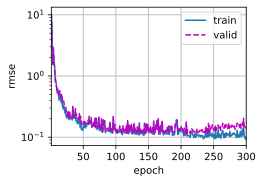

In [ ]:
k = 5
num_epochs = 300
lr = 0.01
weight_decy = 0.001
batch_size = 64
train_l,valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decy, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [23]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decy, batch_size):
    net = get_net()
    train_ls,_ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decy, batch_size)
    d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel="epoch", ylabel="log rmse", xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    # 转换回原始房价
    test_data['SalePrice'] = pd.Series(np.exp(preds.reshape(1,-1)[0]))
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,num_epochs,lr, weight_decy, batch_size)